In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pedro/anaconda3/envs/computer-vision/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [3]:
class MiniVGGNet:
    
    @staticmethod
    def build(width, height, depth, classes, batch_norm=True):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [4]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# load the training and testing data, then scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

[INFO] loading CIFAR-10 data...


In [6]:
# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.transform(testY)

In [7]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [8]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay=0.01 / 40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [9]:
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 12s 241us/step - loss: 1.6069 - acc: 0.4630 - val_loss: 1.2508 - val_acc: 0.5588
Epoch 2/40
50000/50000 [==============================] - 11s 216us/step - loss: 1.1353 - acc: 0.6032 - val_loss: 0.9041 - val_acc: 0.6840
Epoch 3/40
50000/50000 [==============================] - 11s 213us/step - loss: 0.9535 - acc: 0.6667 - val_loss: 0.8075 - val_acc: 0.7174
Epoch 4/40
50000/50000 [==============================] - 11s 222us/step - loss: 0.8538 - acc: 0.7013 - val_loss: 0.9008 - val_acc: 0.6896
Epoch 5/40
50000/50000 [==============================] - 11s 217us/step - loss: 0.7812 - acc: 0.7259 - val_loss: 0.7200 - val_acc: 0.7491
Epoch 6/40
50000/50000 [==============================] - 11s 222us/step - loss: 0.7208 - acc: 0.7462 - val_loss: 0.6784 - val_acc: 0.7619
Epoch 7/40
50000/50000 [==============================] - 11s 216us/step - loss: 0.6799 -

In [10]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.86      0.83      0.85      1000
  automobile       0.91      0.90      0.90      1000
        bird       0.81      0.72      0.76      1000
         cat       0.68      0.68      0.68      1000
        deer       0.78      0.81      0.80      1000
         dog       0.72      0.75      0.74      1000
        frog       0.87      0.88      0.87      1000
       horse       0.87      0.86      0.86      1000
        ship       0.92      0.90      0.91      1000
       truck       0.86      0.91      0.88      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



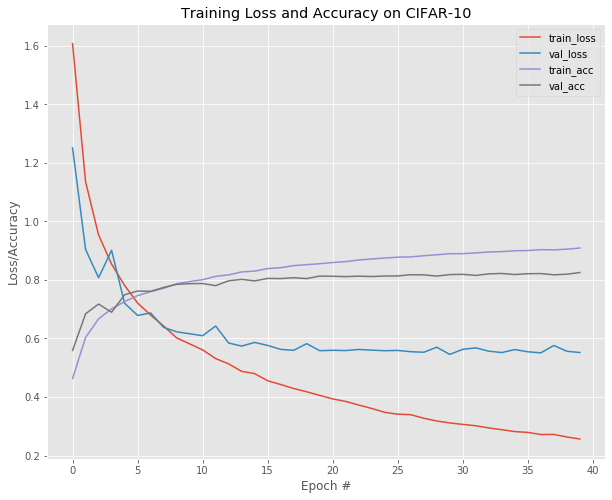

In [11]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [12]:
# initialize the model
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10, batch_norm=False)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=40, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=labelNames))

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 8s 160us/step - loss: 2.1535 - acc: 0.1917 - val_loss: 1.9670 - val_acc: 0.2968
Epoch 2/40
50000/50000 [==============================] - 8s 156us/step - loss: 1.9072 - acc: 0.3079 - val_loss: 1.8125 - val_acc: 0.3586
Epoch 3/40
50000/50000 [==============================] - 8s 152us/step - loss: 1.7313 - acc: 0.3727 - val_loss: 1.5996 - val_acc: 0.4320
Epoch 4/40
50000/50000 [==============================] - 8s 159us/step - loss: 1.6259 - acc: 0.4116 - val_loss: 1.5082 - val_acc: 0.4610
Epoch 5/40
50000/50000 [==============================] - 8s 154us/step - loss: 1.5630 - acc: 0.4346 - val_loss: 1.4631 - val_acc: 0.4710
Epoch 6/40
50000/50000 [==============================] - 8s 165us/step - loss: 1.5039 - acc: 0.4552 - val_loss: 1.4705 - val_acc: 0.4711
Epoch 7/40
50000/50000 [==============================] - 8s 158us/step - loss: 1.4486 - acc: 0

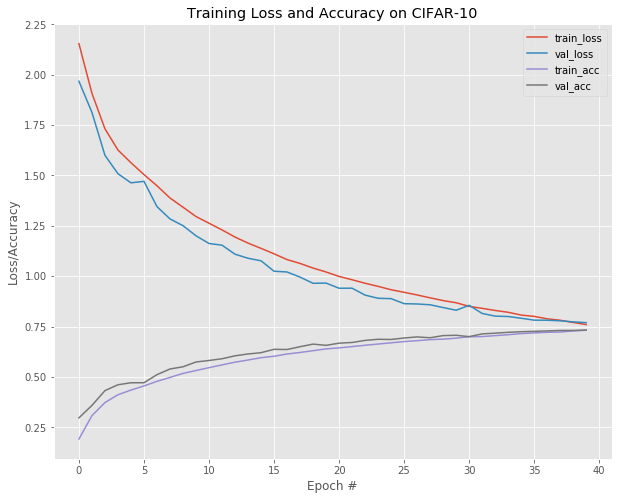

In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()